In [2]:
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt

titanic = sns.load_dataset('titanic')
print(titanic.head())

   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  


In [3]:
clean_tit = titanic.drop(columns=['class', 'who', 'deck', 'embarked', 'alive'])

In [4]:
clean_tit.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
adult_male       0
embark_town      2
alone            0
dtype: int64

In [6]:
clean_tit['age'] = clean_tit['age'].fillna(clean_tit['age'].median())
clean_tit['embark_town'] = clean_tit['embark_town'].fillna(clean_tit['embark_town'].mode()[0])
clean_tit.isnull().sum()

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
adult_male     0
embark_town    0
alone          0
dtype: int64

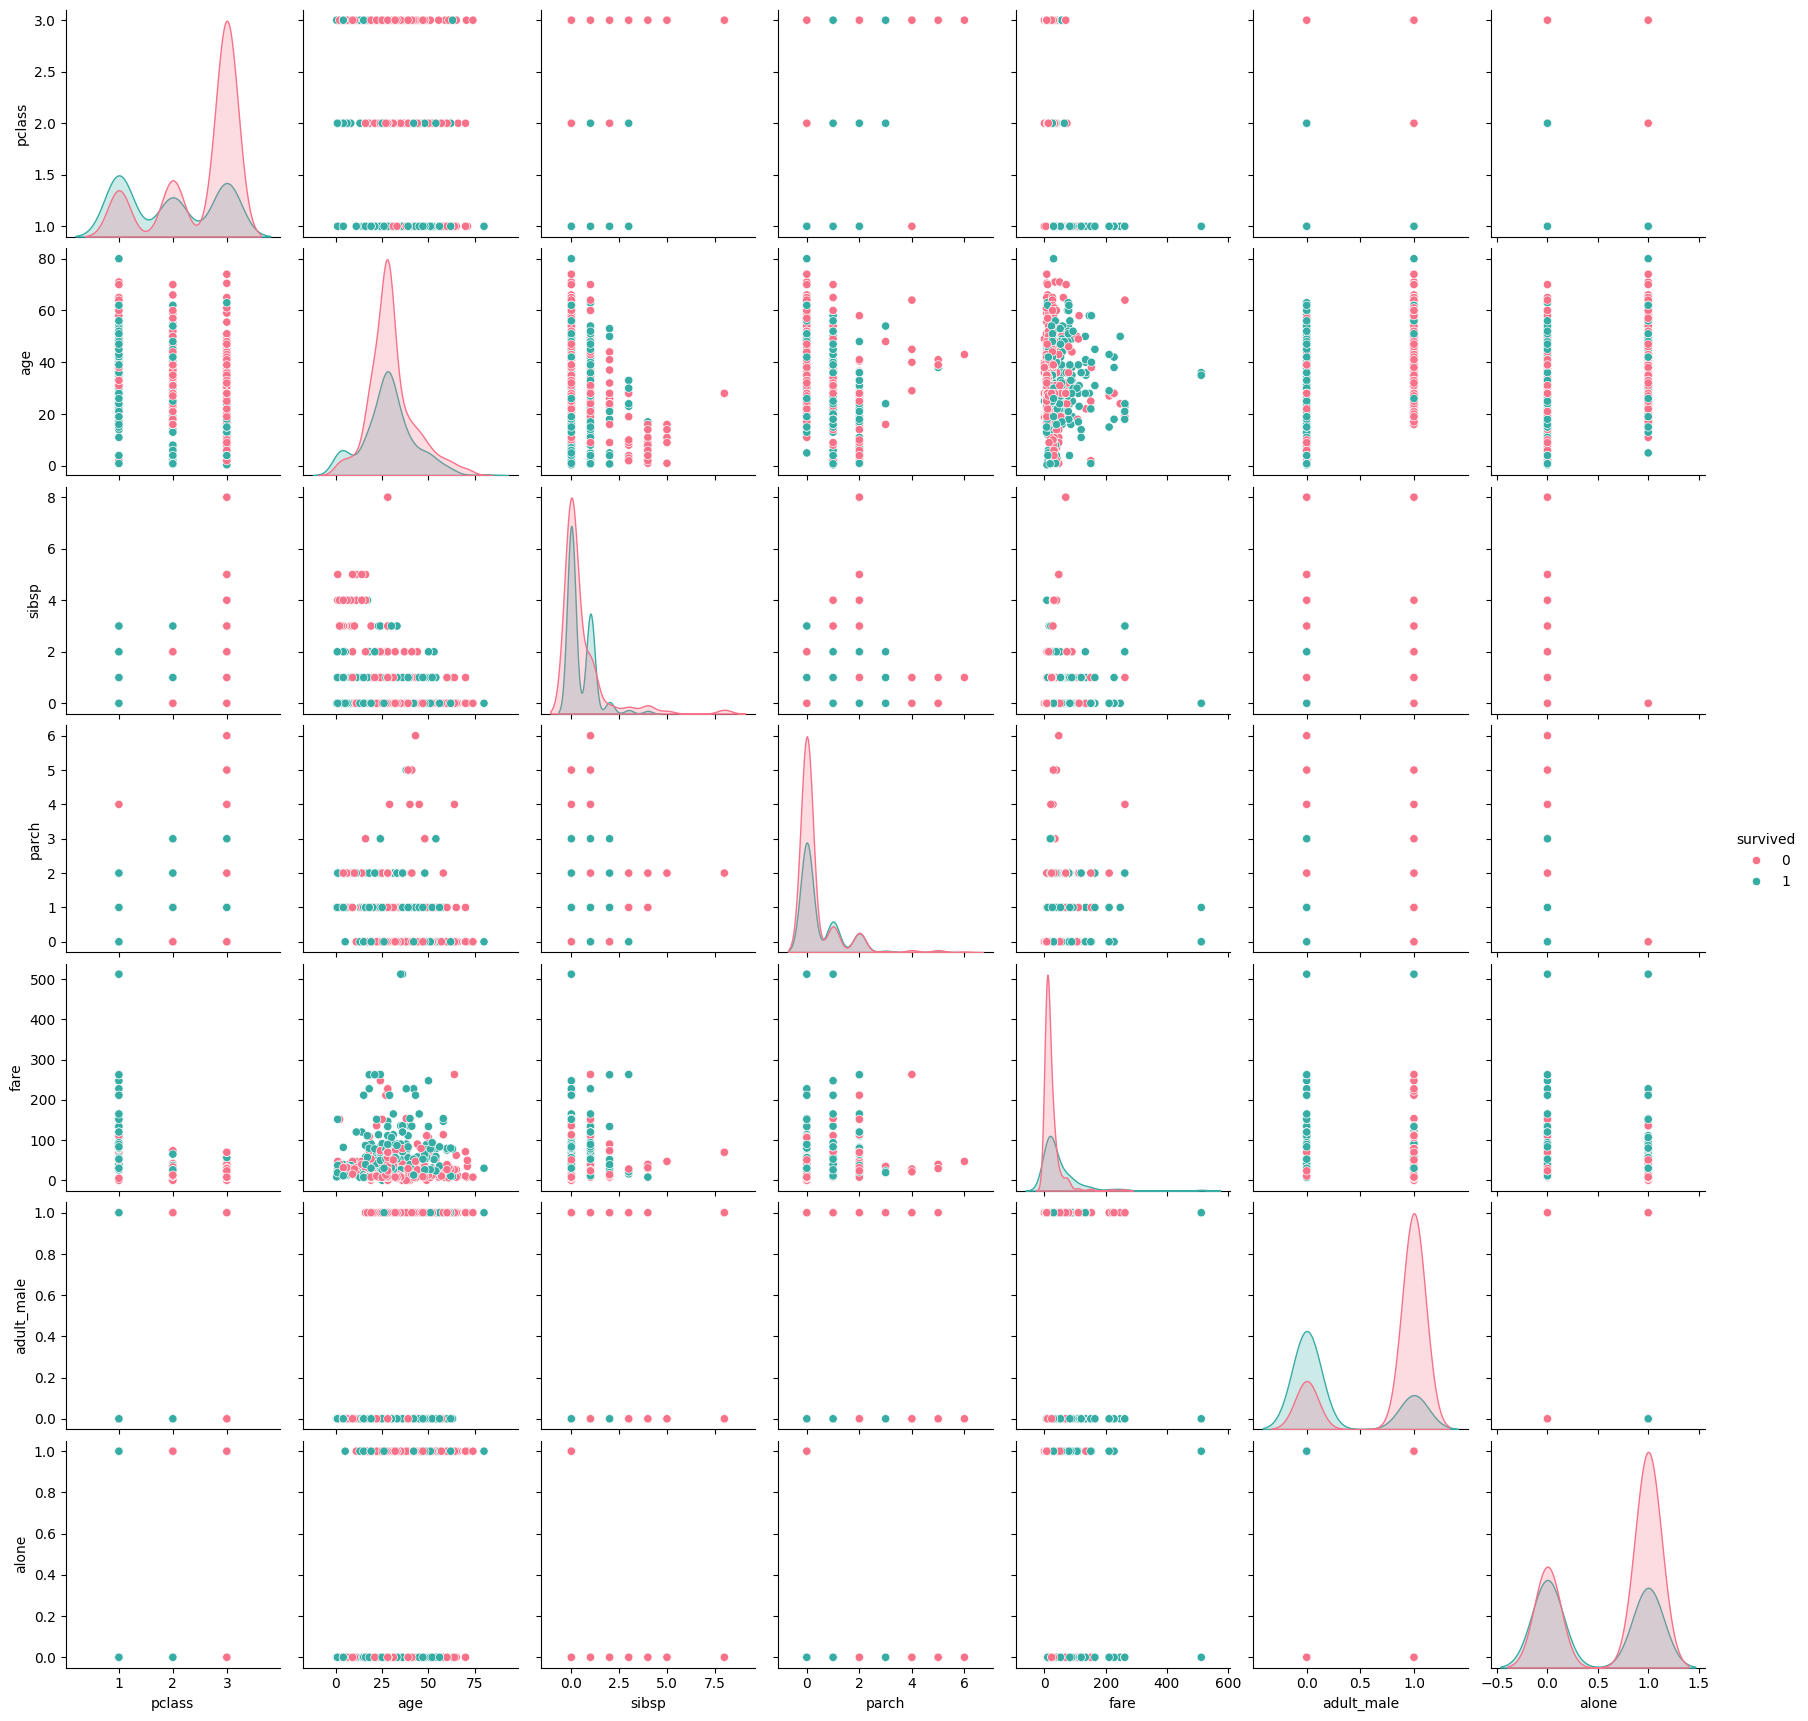

In [7]:
sns.pairplot(data=clean_tit, hue="survived", palette='husl')
plt.show()

# Inference from Pair Plot

we have understood that there is a high correlation between PClass and survival
if you were alone, you had higher chance of survival probably
the plot between age and fair is something not related to our goal, but still needs to be looked into as it seems interesting
Adult males had significantly higher chance of not surviving

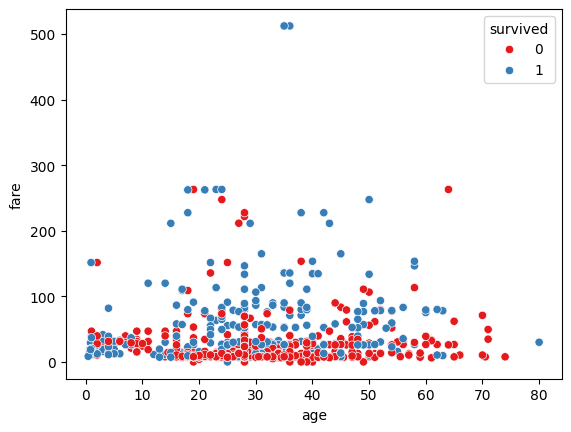

In [10]:
sns.scatterplot(data=clean_tit, x='age', y='fare', hue="survived", palette="Set1")
plt.show()

<Axes: >

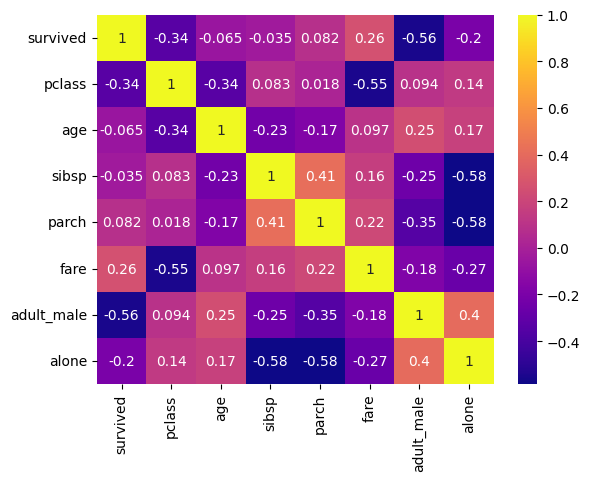

In [14]:
corr_matrix = clean_tit.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='plasma')


high correlations between:
    adult male and alone,
    fare and survival has slight correlation,
    age and fare doesnt really have any interesting result

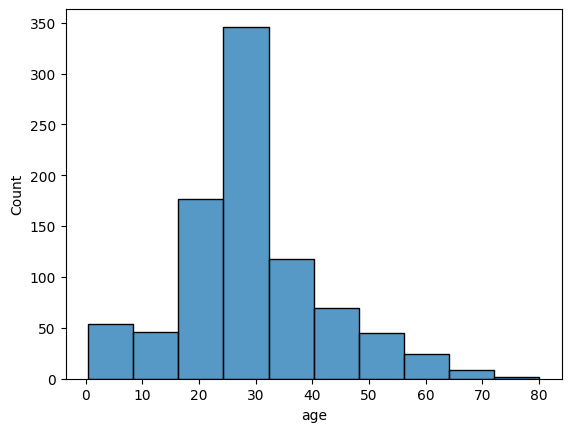

29.36158249158249
13.019696550973201


In [20]:
sns.histplot(clean_tit, x='age', bins=10)
plt.show()
print(clean_tit['age'].mean())
print(clean_tit['age'].std())

A Clear Normal distribution can be seen, with a mean of 29.3616 and standard deviation of 13.0197

In [ ]:
#added family size

clean_tit['family_size'] = clean_tit['sibsp'] + clean_tit['parch'] + 1

<Axes: xlabel='survived', ylabel='family_size'>

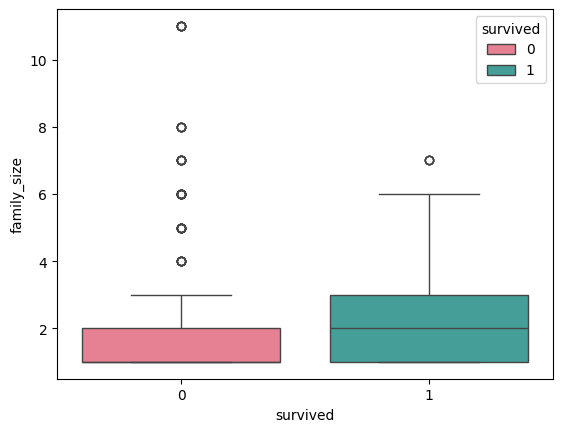

In [22]:
sns.boxplot(x='survived', y='family_size', data=clean_tit, hue='survived', palette='husl')

# We can make a classification model which classifies people into alive or not
- Random Forest

- Best parameters to consider would be family size(need to do some more search on if it is important enough), age, fare, pclass, since gender and adult male seem to do the same thing, we will only consider adult male here since children seem to also have survived most of it

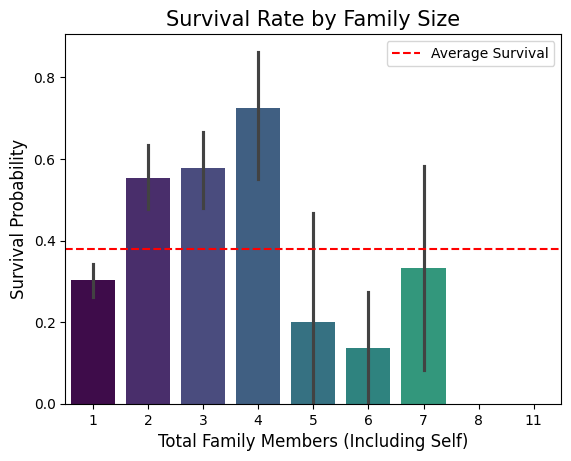

In [ ]:
#checking importance of family size
sns.barplot(data=clean_tit, x='family_size', y='survived', palette='viridis', hue='family_size', legend=False)
plt.title('Survival Rate by Family Size', fontsize=15)
plt.xlabel('Total Family Members (Including Self)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.axhline(0.38, color='red', linestyle='--', label='Average Survival') # average
plt.legend()

plt.show()

# Inference

There seems to be an interesting correlation between the family size and survival probability.
Till family size 4, there seems to be a positive correlation between family size and survivability
But after 4, till 7(max family size), there is a decrease in the survivability chance


This is mostly due to the fact that until one threshold size, family members actually help each other (also evident from the alone showing lesser survivability);
But after that threshold size, they cant really help each other as effectively due to increase in chaos and chance of seeing each other and other factors


## New factor: family category

- Alone: family\_size = 1
- Small: 1 < family\_size < 5
- Large: family\_size > 4


In [27]:
# Define the bins and the labels
# Bins: 0-1 (Alone), 1-4 (Small), 4-11 (Large)
bins = [0, 1, 4, 11]
labels = ['Alone', 'Small', 'Large']

clean_tit['family_category'] = pd.cut(clean_tit['family_size'], bins=bins, labels=labels)

# Let's see the survival rate for these new groups
print(clean_tit.groupby('family_category')['survived'].mean())

family_category
Alone    0.303538
Small    0.578767
Large    0.161290
Name: survived, dtype: float64


C:\Users\vasus\AppData\Local\Temp\ipykernel_19488\3914860759.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(clean_tit.groupby('family_category')['survived'].mean())


Model Accuracy: 81.01%


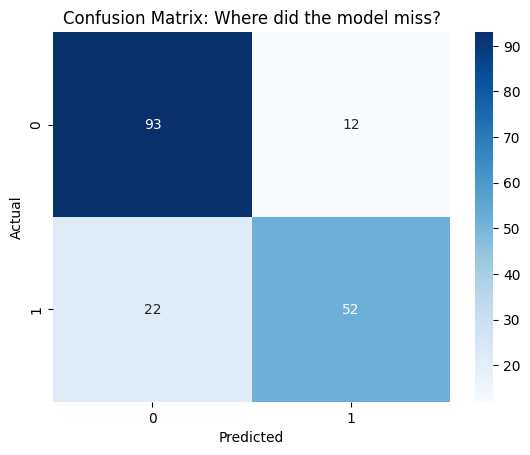

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

features = ['pclass', 'fare', 'age', 'adult_male', 'family_category']
X = clean_tit[features]
y = clean_tit['survived']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, predictions):.2%}")

sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Where did the model miss?')
plt.show()

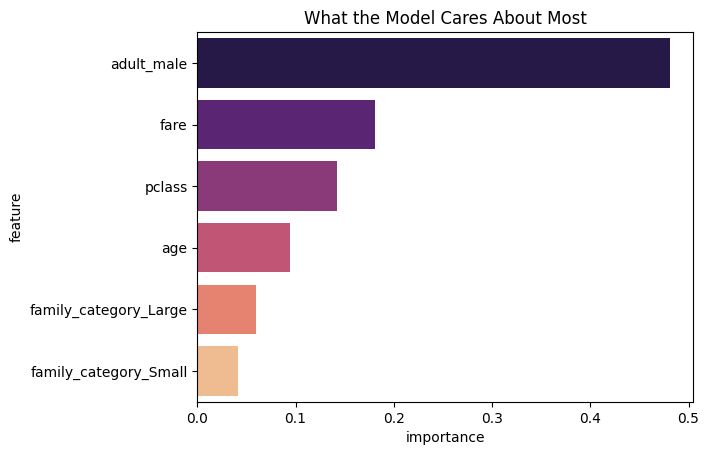

In [34]:
importances = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})
importances = importances.sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=importances, palette='magma', hue='feature')
plt.title("What the Model Cares About Most")
plt.show()


# Result

We have created a model with test accuracy of 81.01% which is great

The most important factor here seems to have been Adult_Male, as seen from the data exploration above